In [55]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [56]:
def get_zeroth_moment(x, n_x, dx, zeroth_moment):
    x_index = np.floor(x[0, :] / dx).astype(np.int64)

    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    index_one_array = x_index

    zeroth_moment += np.bincount(index_one_array, 
                       weights=cx2,
                       minlength=n_x
                      )
    zeroth_moment += np.roll(np.bincount(index_one_array, 
                               weights=cx1,
                               minlength=n_x
                              ), 1, axis=0)
    
    return zeroth_moment


def get_first_moment(c, v, x, n_x, dx, first_moment):
    x_index = np.floor(x[0, :] / dx).astype(int)

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    index_one_array = x_index

    first_moment[0, :] += np.bincount(index_one_array, 
                                 weights=v[0, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    first_moment[0, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[0, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    first_moment[1, :] += np.bincount(index_one_array, 
                                 weights=v[1, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    first_moment[1, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[1, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    first_moment[2, :] += np.bincount(index_one_array, 
                                 weights=v[2, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    first_moment[2, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[2, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)

    return first_moment


def get_second_moment(c, v, x, n_x, dx, second_moment):
    x_index = np.floor(x[0, :] / dx).astype(int)

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    cx1 = (x[0, :] - x_index*dx)/dx  
    cx2 = ((x_index+1)*dx - x[0, :])/dx 
    index_one_array = x_index

    second_moment[0, :] += np.bincount(index_one_array, 
                                 weights=v[0, :]/gamma * v[0, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[0, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[0, :]/gamma * v[0, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[1, :] += np.bincount(index_one_array, 
                                 weights=v[0, :]/gamma * v[1, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[1, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[0, :]/gamma * v[1, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[2, :] += np.bincount(index_one_array, 
                                 weights=v[0, :]/gamma * v[2, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[2, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[0, :]/gamma * v[2, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[3, :] = second_moment[1, :]
    second_moment[4, :] += np.bincount(index_one_array, 
                                 weights=v[1, :]/gamma * v[1, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[4, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[1, :]/gamma * v[1, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[5, :] += np.bincount(index_one_array, 
                                 weights=v[1, :]/gamma * v[2, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[5, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[1, :]/gamma * v[2, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)
    second_moment[6, :] = second_moment[2, :]
    second_moment[7, :] = second_moment[5, :]
    second_moment[8, :] += np.bincount(index_one_array, 
                                 weights=v[2, :]/gamma * v[2, :]/gamma * cx2, 
                                 minlength=n_x
                                )
    second_moment[8, :] += np.roll(np.bincount(index_one_array, 
                                         weights=v[2, :]/gamma * v[2, :]/gamma * cx1, 
                                         minlength=n_x
                                        ), 1, axis=0)

    return second_moment


def open_condition_x_left(v_pic, x_pic, x_min):

    delete_index = np.where(x_pic[0, :] < x_min) 
    x_pic = np.delete(x_pic, delete_index, axis=1)
    v_pic = np.delete(v_pic, delete_index, axis=1)

    return v_pic, x_pic


In [58]:
def reset_particles(
        zeroth_moment_pic, bulk_speed_pic, v_th_squared_pic,
        index_interface_pic_start, index_interface_pic_end, 
        dx, v_pic, x_pic
    ):
    
    delete_index = np.where((x_pic[0, :] < index_interface_pic_end * dx - 0.5 * dx)
                            & ((x_pic[0, :] > index_interface_pic_start * dx - 0.5 * dx)))[0]
    x_pic = np.delete(x_pic, delete_index, axis=1)
    v_pic = np.delete(v_pic, delete_index, axis=1)

    for i in range(len(zeroth_moment_pic)):
        new_particles_v = np.zeros([3, round(zeroth_moment_pic[i])])
        new_particles_x = np.zeros([3, round(zeroth_moment_pic[i])])
        random_number = np.random.randint(1, 10000)
        new_particles_v[0, :] = np.asarray(
            stats.norm.rvs(bulk_speed_pic[0, i], np.sqrt(v_th_squared_pic[i]), size=round(zeroth_moment_pic[i]), random_state=random_number)
        )
        random_number = np.random.randint(1, 10000)
        new_particles_v[1, :] = np.asarray(
            stats.norm.rvs(bulk_speed_pic[1, i], np.sqrt(v_th_squared_pic[i]), size=round(zeroth_moment_pic[i]), random_state=random_number)
        )
        random_number = np.random.randint(1, 10000)
        new_particles_v[2, :] = np.asarray(
            stats.norm.rvs(bulk_speed_pic[2, i], np.sqrt(v_th_squared_pic[i]), size=round(zeroth_moment_pic[i]), random_state=random_number)
        )
        random_number = np.random.randint(1, 10000)
        rs = np.random.RandomState(random_number)
        #new_particles_x[0, :] = (rs.rand(round(zeroth_moment_pic[i])) - 0.5) * dx \
        #                      + (index_interface_pic_start + i) * dx
        new_particles_x[0, :] = (np.linspace(-0.5, 0.5, round(zeroth_moment_pic[i]))) * dx \
                              + (index_interface_pic_start + i) * dx

        v_pic = np.hstack([v_pic, new_particles_v])
        x_pic = np.hstack([x_pic, new_particles_x])
    
    v_pic, x_pic = open_condition_x_left(v_pic, x_pic, 0.0)

    return v_pic, x_pic

In [62]:
c = 0.5
mu_0 = 1.0
epsilon0 = 1.0 / (mu_0 * c**2)
m_electron = 1.0
r_m = 1 / 100
m_ion = m_electron / r_m
t_r = 1.0
ne0_pic = 20 #ここは手動で調整すること
ni0_pic = ne0_pic
B0_pic = np.sqrt(ne0_pic) / 1.0
Te_pic = 0.5 * m_electron * (0.2*c)**2
Ti_pic = Te_pic / t_r
beta_pic = (ne0_pic * Te_pic + ni0_pic * Ti_pic) / (B0_pic**2 / 2 / mu_0)
q_electron = -1 * np.sqrt(epsilon0 * Te_pic / ne0_pic)
q_ion = -1 * q_electron
debye_length = np.sqrt(epsilon0 * Te_pic / ne0_pic / q_electron**2)
omega_pe = np.sqrt(ne0_pic * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(ni0_pic * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0_pic / m_electron
omega_ci = q_ion * B0_pic / m_ion
v_ion = np.array([0.0, 0.0, 0.0])
v_electron = np.array([0.0, 0.0, 0.0])
v_thermal_electron = np.sqrt(2.0 * Te_pic / m_electron)
v_thermal_ion = np.sqrt(2.0 * Ti_pic / m_ion)

dx_pic = debye_length
nx_pic = 100
x_min_pic = 1e-10
x_max_pic = nx_pic * dx_pic - 1e-10
x_coordinate_pic = np.arange(0.0, x_max_pic, dx_pic)
dt_pic = 0.0
d_pic = 1.0

E_pic = np.zeros([3, nx_pic])
B_pic = np.zeros([3, nx_pic])
current_pic = np.zeros([3, nx_pic])
rho_pic = np.zeros(nx_pic)
B_pic[2, :] = B0_pic

n_ion = int(ni0_pic * nx_pic)
n_electron = int(n_ion * abs(q_ion / q_electron))
x_pic_ion = np.zeros([3, n_ion])
x_pic_electron = np.zeros([3, n_electron])
v_pic_ion = np.zeros([3, n_ion])
v_pic_electron = np.zeros([3, n_electron])

rs_ion = np.random.RandomState(10)
rs_electron = np.random.RandomState(20)
x_start_ion = np.linspace(x_min_pic, x_max_pic, n_ion)
x_start_electron = np.linspace(x_min_pic, x_max_pic, n_electron)

x_pic_ion[0, :] = x_start_ion
x_pic_electron[0, :] = x_start_electron
v_pic_ion[0, :] = np.asarray(stats.norm.rvs(v_ion[0], v_thermal_ion, size=n_ion, random_state=30))
v_pic_ion[1, :] = np.asarray(stats.norm.rvs(v_ion[1], v_thermal_ion, size=n_ion, random_state=40))
v_pic_ion[2, :] = np.asarray(stats.norm.rvs(v_ion[2], v_thermal_ion, size=n_ion, random_state=50))
v_pic_electron[0, :] = np.asarray(stats.norm.rvs(v_electron[0], v_thermal_electron, size=n_electron, random_state=60))
v_pic_electron[1, :] = np.asarray(stats.norm.rvs(v_electron[1], v_thermal_electron, size=n_electron, random_state=70))
v_pic_electron[2, :] = np.asarray(stats.norm.rvs(v_electron[2], v_thermal_electron, size=n_electron, random_state=80))

print(f"total number of particles is {n_ion + n_electron}.")
print(f"Box size is {nx_pic}")

total number of particles is 4000.
Box size is 100


In [63]:
index_interface_pic_start = 40
index_interface_pic_end = 60

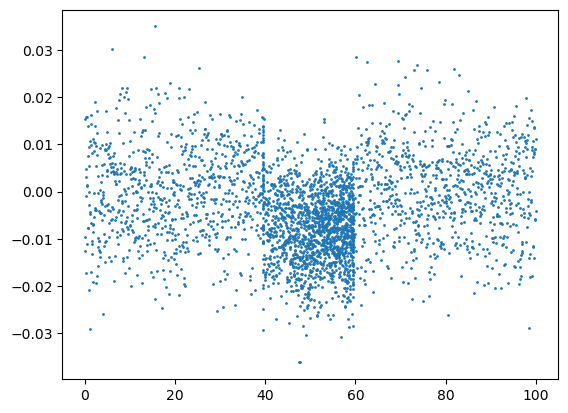

In [68]:
for i in range(10):
    zeroth_moment_ion = np.zeros(nx_pic)
    zeroth_moment_electron = np.zeros(nx_pic)
    zeroth_moment_ion = get_zeroth_moment(x_pic_ion, nx_pic, dx_pic, zeroth_moment_ion)
    zeroth_moment_electron = get_zeroth_moment(x_pic_electron, nx_pic, dx_pic, zeroth_moment_electron)
    first_moment_ion = np.zeros([3, nx_pic])
    first_moment_electron = np.zeros([3, nx_pic])
    first_moment_ion = get_first_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, first_moment_ion)
    first_moment_electron = get_first_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, first_moment_electron)
    second_moment_ion = np.zeros([9, nx_pic])
    second_moment_electron = np.zeros([9, nx_pic])
    second_moment_ion = get_second_moment(c, v_pic_ion, x_pic_ion, nx_pic, dx_pic, second_moment_ion)
    second_moment_electron = get_second_moment(c, v_pic_electron, x_pic_electron, nx_pic, dx_pic, second_moment_electron)

    zeroth_moment_ion[0] = zeroth_moment_ion[1]
    zeroth_moment_electron[-1] = zeroth_moment_electron[-2]
    first_moment_ion[:, 0] = first_moment_ion[:, 1]
    first_moment_electron[:, -1] = first_moment_electron[:, -2]
    second_moment_ion[:, 0] = second_moment_ion[:, 1]
    second_moment_electron[:, -1] = second_moment_electron[:, -2]


    bulk_speed_ion_pic = first_moment_ion / (zeroth_moment_ion + 1e-10)
    bulk_speed_electron_pic = first_moment_electron / (zeroth_moment_electron + 1e-10)
    v_thi_squared_pic = ((second_moment_ion[0, :] + second_moment_ion[4, :] + second_moment_ion[8, :])
                        - zeroth_moment_ion * (bulk_speed_ion_pic[0, :]**2 + bulk_speed_ion_pic[1, :]**2 + bulk_speed_ion_pic[2, :]**2)) \
                        / 3.0 / (zeroth_moment_ion + 1e-10)
    v_the_squared_pic = ((second_moment_electron[0, :] + second_moment_electron[4, :] + second_moment_electron[8, :])
                        - zeroth_moment_electron * (bulk_speed_electron_pic[0, :]**2 + bulk_speed_electron_pic[1, :]**2 + bulk_speed_electron_pic[2, :]**2)) \
                        / 3.0 / (zeroth_moment_electron + 1e-10)
    
    zeroth_moment_ion = zeroth_moment_ion[index_interface_pic_start:index_interface_pic_end]
    zeroth_moment_electron = zeroth_moment_electron[index_interface_pic_start:index_interface_pic_end]
    bulk_speed_ion_pic = bulk_speed_ion_pic[:, index_interface_pic_start:index_interface_pic_end]
    bulk_speed_electron_pic = bulk_speed_electron_pic[:, index_interface_pic_start:index_interface_pic_end]
    v_thi_squared_pic = v_thi_squared_pic[index_interface_pic_start:index_interface_pic_end]
    v_the_squared_pic = v_the_squared_pic[index_interface_pic_start:index_interface_pic_end]
    
    v_pic_ion, x_pic_ion = reset_particles(
        zeroth_moment_ion, bulk_speed_ion_pic, v_thi_squared_pic,
        index_interface_pic_start, index_interface_pic_end,
        dx_pic, v_pic_ion, x_pic_ion
    )
    v_pic_electron, x_pic_electron = reset_particles(
        zeroth_moment_electron, bulk_speed_electron_pic, v_the_squared_pic,
        index_interface_pic_start, index_interface_pic_end, 
        dx_pic, v_pic_electron, x_pic_electron
    )

plt.scatter(x_pic_ion[0, :], v_pic_ion[0, :], s=1)

---

def get_zeroth_moment(x, n_x, dx, zeroth_moment):
    x_index = np.floor(x[0, :] / dx).astype(np.int64)

    index_one_array = x_index

    zeroth_moment += np.bincount(index_one_array)
    
    return zeroth_moment


def get_first_moment(c, v, x, n_x, dx, first_moment):
    x_index = np.floor(x[0, :] / dx).astype(int)

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    index_one_array = x_index

    first_moment[0, :] += np.bincount(index_one_array, weights=v[0, :]/gamma)
    first_moment[1, :] += np.bincount(index_one_array, weights=v[1, :]/gamma)
    first_moment[2, :] += np.bincount(index_one_array, weights=v[2, :]/gamma)

    return first_moment


def get_second_moment(c, v, x, n_x, dx, second_moment):
    x_index = np.floor(x[0, :] / dx).astype(int)

    gamma = np.sqrt(1.0 + (np.linalg.norm(v, axis=0)/c)**2)

    index_one_array = x_index

    second_moment[0, :] += np.bincount(index_one_array,
                                       weights=v[0, :]/gamma * v[0, :]/gamma)
    second_moment[1, :] += np.bincount(index_one_array,
                                       weights=v[0, :]/gamma * v[1, :]/gamma)
    second_moment[2, :] += np.bincount(index_one_array,
                                       weights=v[0, :]/gamma * v[2, :]/gamma)
    second_moment[3, :] += np.bincount(index_one_array,
                                       weights=v[1, :]/gamma * v[0, :]/gamma)
    second_moment[4, :] += np.bincount(index_one_array,
                                       weights=v[1, :]/gamma * v[1, :]/gamma)
    second_moment[5, :] += np.bincount(index_one_array,
                                       weights=v[1, :]/gamma * v[2, :]/gamma)
    second_moment[6, :] += np.bincount(index_one_array,
                                       weights=v[2, :]/gamma * v[0, :]/gamma)
    second_moment[7, :] += np.bincount(index_one_array,
                                       weights=v[2, :]/gamma * v[1, :]/gamma)
    second_moment[8, :] += np.bincount(index_one_array,
                                       weights=v[2, :]/gamma * v[2, :]/gamma)

    return second_moment


def open_condition_x_left(v_pic, x_pic, x_min):

    delete_index = np.where(x_pic[0, :] < x_min) 
    x_pic = np.delete(x_pic, delete_index, axis=1)
    v_pic = np.delete(v_pic, delete_index, axis=1)

    return v_pic, x_pic
